In [149]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
seed = 888

In [150]:
# Load datasets
file_paths = {
    "customer": "../../data/processed/customer.csv",
    "customer_segments": "../../customer_segmentation/customer_segments.csv",
    "digital_usage": "../../data/processed/digital_usage.csv",
    "products_owned": "../../data/processed/products_owned.csv",
    "loans": "../../data/processed/loans.csv",
    "transactions": "../../data/processed/transactions.csv",
}

dataframes = {name: pd.read_csv(path) for name, path in file_paths.items()}

In [151]:
# Merge datasets using 'customer_id' as the key
df_merged = dataframes["customer"]
df_merged = df_merged.merge(dataframes["digital_usage"], on="customer_id", how="left")
df_merged = df_merged.merge(dataframes["customer_segments"], on="customer_id", how="left")
df_merged = df_merged.merge(dataframes["products_owned"], on="customer_id", how="left")
df_merged = df_merged.merge(dataframes["loans"], on="customer_id", how="left")
df_merged = df_merged.merge(dataframes["transactions"], on="customer_id", how="left")

# Convert transaction date to datetime format
df_merged["transaction_date"] = pd.to_datetime(df_merged["transaction_date"], errors="coerce")
df_merged["paid_off_date"] = pd.to_datetime(df_merged["paid_off_date"], errors="coerce")
df_merged["due_date"] = pd.to_datetime(df_merged["due_date"], errors="coerce")
df_merged["last_mobile_use"] = pd.to_datetime(df_merged["last_mobile_use"], errors="coerce")
df_merged["last_web_use"] = pd.to_datetime(df_merged["last_web_use"], errors="coerce")

In [ ]:
# Feature Engineering
df_merged["debt_to_income_ratio"] = df_merged["debt"] / df_merged["income"]
df_merged["total_products_owned"] = df_merged[
    ["has_investment_product", "has_credit_card", "has_fixed_deposit", "has_insurance"]
].sum(axis=1)

In [153]:
# Define churn indicator (customers inactive for 6+ months since the last transaction of dataset)
latest_transaction = df_merged.groupby("customer_id")["transaction_date"].max()
latest_digital_usage = df_merged.groupby("customer_id")[["last_mobile_use", "last_web_use"]].max()
max_transaction_date = df_merged["transaction_date"].max()

churn_threshold_date = max_transaction_date - pd.DateOffset(days=15)
churn_threshold_date_unpaid_loan = max_transaction_date - pd.DateOffset(months=12)
digital_usage_threshold = max_transaction_date - pd.DateOffset(months=6)

has_unpaid_loan = df_merged.groupby("customer_id")["paid_off_date"].apply(lambda x: x.isna().any())

def is_churn(customer_id):
    last_txn = latest_transaction.get(customer_id, pd.NaT)
    unpaid_loan = has_unpaid_loan.get(customer_id, False)

    if unpaid_loan:
        if pd.isna(last_txn) or last_txn < churn_threshold_date_unpaid_loan:
            return True
    
    last_mobile = latest_digital_usage.loc[customer_id, "last_mobile_use"]
    last_web = latest_digital_usage.loc[customer_id, "last_web_use"]
    
    digital_inactive = (pd.isna(last_mobile) or last_mobile < digital_usage_threshold) and \
                       (pd.isna(last_web) or last_web < digital_usage_threshold)
    
    return (pd.isna(last_txn) or last_txn < churn_threshold_date) and digital_inactive
df_merged["churn_risk"] = df_merged["customer_id"].map(is_churn)

In [154]:
# Prepare dataset for model training
features = [
    "age", "tenure", "balance", "debt", "income", "debt_to_income_ratio",
    "total_products_owned", "nps", "dependents", "has_mobile_app", "has_web_account", 
    "mobile_logins_wk", "web_logins_wk"
]

df_clean = df_merged.dropna(subset=features + ["churn_risk"]).copy()
X = df_clean[features]
y = df_clean["churn_risk"].astype(str)
customer_ids = df_clean["customer_id"]

# Split before applying SMOTE
X_train, X_test, y_train, y_test, customer_train, customer_test = train_test_split(
    X, y, customer_ids, test_size=0.2, random_state=seed, stratify=y
)

smote = SMOTE(sampling_strategy='auto', random_state=seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=seed)

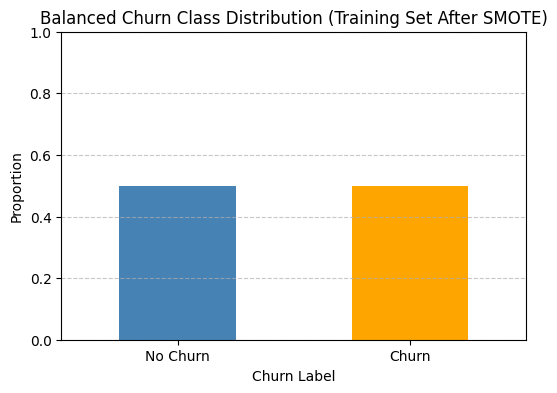

In [155]:
plt.figure(figsize=(6, 4))
pd.Series(y_train_resampled).value_counts(normalize=True).plot(kind="bar", color=["steelblue", "orange"])
plt.title("Balanced Churn Class Distribution (Training Set After SMOTE)")
plt.xlabel("Churn Label")
plt.ylabel("Proportion")
plt.xticks(ticks=[0, 1], labels=["No Churn", "Churn"], rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [156]:
# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=50, random_state=seed)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
report = classification_report(y_test, y_pred)

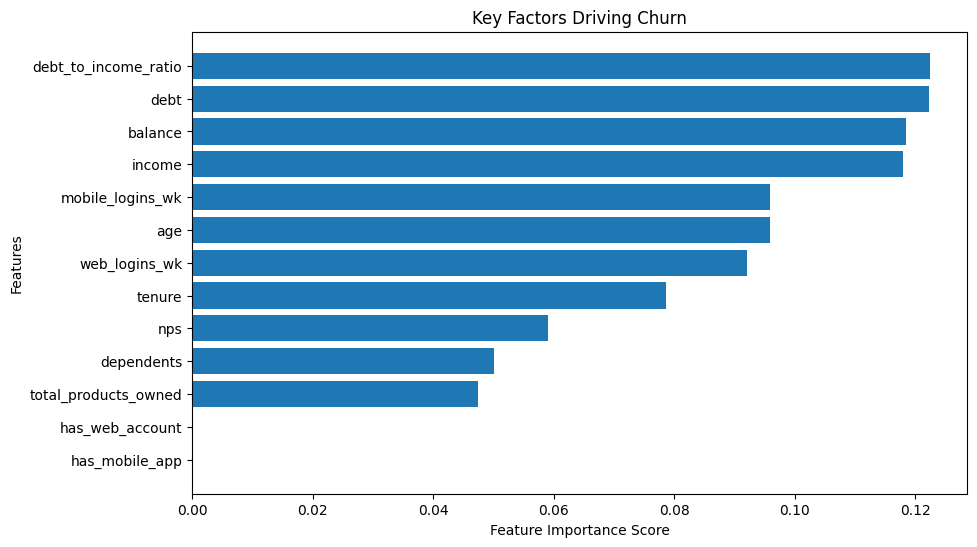

In [157]:
feature_importance = rf_model.feature_importances_
feature_names = np.array(features)

sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx], align="center")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Key Factors Driving Churn")
plt.gca().invert_yaxis()  
plt.show()


In [158]:
# Ensure df_clean is a full copy, not a view
report = classification_report(
    y_test, 
    y_pred, 
    target_names=["Non-Churn", "Churn"]
)

df_clean = df_clean.copy()

df_clean.loc[:, "churn_risk_score"] = rf_model.predict_proba(X)[:, 1]

df_clean.loc[:, "risk_level"] = pd.cut(
    df_clean["churn_risk_score"],
    bins=[0, 0.3, 0.7, 1],
    labels=["Low", "Medium", "High"],
    include_lowest=True
)

df_clean["churn_label"] = df_clean["churn_risk"].replace({True: "Churn", False: "Non-Churn"})

In [159]:
# Save Early Warning Report
warning_report = df_clean[
    ["customer_id", "age", "tenure", "balance", "debt_to_income_ratio", "total_products_owned", 
     "nps", "has_mobile_app", "has_web_account", 
     "churn_risk_score", "risk_level", "churn_label"]
].sort_values(by="churn_risk_score", ascending=False)

warning_report.to_csv("churn_warning_report.csv", index=False)
print("Churn Early Warning Report saved as 'churn_warning_report.csv'.")
print(report)

Churn Early Warning Report saved as 'churn_warning_report.csv'.
              precision    recall  f1-score   support

   Non-Churn       0.95      1.00      0.97      2220
       Churn       0.99      0.84      0.91       725

    accuracy                           0.96      2945
   macro avg       0.97      0.92      0.94      2945
weighted avg       0.96      0.96      0.96      2945

